---
title: "Asset Allocation & Investment Strategies - 1st Assignment"
author:
  - Group 1
  - Azim Balci, Mayeul Perret, Rodolphe Lajugie, Theodosis Kaplanidis, Zihua Du
date: "2026-01-20"
format: pdf
---
\newpage
\tableofcontents
\listoffigures
\listoftables
\newpage

## Importing Python Libraries and Statistical Packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import t
import quadprog

## Loading and Preprocessing Stock and Currency Data

Initially, data cleaning and extraction are performed. Specifically, the provided Excel spreadsheet is modified by isolating the cells containing exchange rates from the worksheet titled *“hard_copy”* and transferring them to a new worksheet named *“value_used”*.

In [2]:
# Load and preprocess the data
df_stock = pd.read_excel("PS1_data.xlsx", sheet_name="hard_copy", header=None)
df_stock.drop([0,1], inplace = True)
df_stock.columns = df_stock.iloc[0]
df_stock = df_stock[1:]
df_stock.columns.name = None
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock.set_index(df_stock['date'], inplace=True)
df_stock.drop(['date'], axis = 1, inplace=True)
df_stock = df_stock.astype(float, errors='ignore')
df_stock = df_stock.round(3)

In [3]:
#| tbl-cap: "Daily Closing Prices of Equity Indices"
df_stock.head()

,TSX,CAC,DAX,Eurostoxx50,NIKKEI225,FTSE100,SP500,IBOVESPA
date,,,,,,,,
2007-03-30,13165.5,5634.16,6917.03,4181.03,17287.650,6308.03,1420.86,45805.0
2007-04-02,13265.8,5645.56,6937.17,4189.55,17028.410,6315.53,1424.55,45597.0
2007-04-03,13361.2,5711.91,7045.56,4246.30,17244.051,6366.11,1437.77,46288.0
2007-04-04,13448.3,5739.01,7073.91,4261.83,17544.090,6364.70,1439.37,46554.0
2007-04-05,13425.0,5741.38,7099.91,4271.54,17491.420,6397.34,1443.76,46647.0


Subsequently, the data from the remaining worksheet are loaded to enable the conversion of all prices into U.S. dollars (USD).

In [4]:
# Load and preprocess the currency data
df_currencies = pd.read_excel('PS1_data.xlsx', sheet_name = 'value_usd', 
                              header=None)
df_currencies.drop([0, 1], inplace=True)
df_currencies.columns = df_currencies.iloc[0]
df_currencies = df_currencies[1:]
df_currencies.columns.name = None
df_currencies['date'] = pd.to_datetime(df_currencies['date'])
df_currencies.set_index(df_currencies['date'], inplace=True)
df_currencies.drop(['date'], axis=1, inplace=True)
df_currencies = df_currencies.astype(float, errors='ignore')

In [5]:
#| tbl-cap: "Daily Exchange Rates of Currencies against USD"
df_currencies.head()

,TSX,CAC,DAX,Eurostoxx50,NIKKEI225,FTSE100,SP500,IBOVESPA
date,,,,,,,,
2007-03-30,0.866326,1.335898,1.335898,1.335898,0.008488,1.952515,1.0,0.486618
2007-04-02,0.864902,1.337006,1.337006,1.337006,0.008492,1.978200,1.0,0.489357
2007-04-03,0.863148,1.332498,1.332498,1.332498,0.008413,1.973399,1.0,0.491666
2007-04-04,0.863036,1.337399,1.337399,1.337399,0.008420,1.976402,1.0,0.492926
2007-04-05,0.868885,1.343201,1.343201,1.343201,0.008425,1.971492,1.0,0.493243


The subsequent dataframe comprises the stock prices denominated in U.S. dollars (USD).

In [6]:
# Convert stock prices to USD
df_stock_usd = df_stock * df_currencies
df_stock_usd = df_stock_usd.round(2)

In [7]:
#| tbl-cap: "Daily Closing Prices of Equity Indices in USD"
df_stock_usd.head()

,TSX,CAC,DAX,Eurostoxx50,NIKKEI225,FTSE100,SP500,IBOVESPA
date,,,,,,,,
2007-03-30,11405.61,7526.66,9240.45,5585.43,146.74,12316.52,1420.86,22289.54
2007-04-02,11473.62,7548.15,9275.04,5601.45,144.61,12493.38,1424.55,22313.21
2007-04-03,11532.69,7611.11,9388.19,5658.19,145.07,12562.88,1437.77,22758.24
2007-04-04,11606.37,7675.35,9460.64,5699.77,147.72,12579.21,1439.37,22947.68
2007-04-05,11664.78,7711.83,9536.61,5737.54,147.37,12612.30,1443.76,23008.31


## Question 1

Subsequently, logarithmic returns are computed for all stocks.

In [8]:
# | tbl-cap: "Daily Log Returns of Equity Indices in USD"
df_returns = np.log(df_stock_usd / df_stock_usd.shift(1))
df_returns.drop([df_returns.index[0]], axis=0, inplace=True)
df_returns = df_returns.round(4)
df_returns.head()

,TSX,CAC,DAX,Eurostoxx50,NIKKEI225,FTSE100,SP500,IBOVESPA
date,,,,,,,,
2007-04-02,0.0059,0.0029,0.0037,0.0029,-0.0146,0.0143,0.0026,0.0011
2007-04-03,0.0051,0.0083,0.0121,0.0101,0.0032,0.0055,0.0092,0.0197
2007-04-04,0.0064,0.0084,0.0077,0.0073,0.0181,0.0013,0.0011,0.0083
2007-04-05,0.0050,0.0047,0.0080,0.0066,-0.0024,0.0026,0.0030,0.0026
2007-04-10,0.0038,0.0043,0.0094,0.0070,0.0063,0.0033,0.0032,0.0114


Subsequently, descriptive information regarding the stocks is presented. The mean values and standard deviations of the indices are illustrated in the chart below.

In [9]:
#| tbl-cap: "Summary Statistics of Daily Log Returns of Equity Indices in USD"
# //TODO  # need to be tested
df_returns.describe().drop(index="count")

,TSX,CAC,DAX,Eurostoxx50,NIKKEI225,FTSE100,SP500,IBOVESPA
mean,0.000116,0.000025,0.000208,-0.000042,0.000166,-0.000064,0.000374,-0.000060
std,0.015251,0.018351,0.018058,0.018482,0.016162,0.015375,0.013581,0.024794
min,-0.134800,-0.135900,-0.135400,-0.137300,-0.180200,-0.122200,-0.127700,-0.196700
25%,-0.005600,-0.007700,-0.007400,-0.007700,-0.007000,-0.006900,-0.004300,-0.011400
50%,0.001000,0.000600,0.000700,0.000600,0.000500,0.000300,0.000800,0.000000
75%,0.006800,0.008500,0.008525,0.008600,0.007900,0.007400,0.006200,0.012500
max,0.111700,0.242900,0.233200,0.243600,0.176500,0.133100,0.104200,0.258900


Subsequently, the skewness of the return distributions is examined.

In [10]:
#| tbl-cap: "Skewness of Daily Log Returns of Equity Indices in USD"
df_returns.skew()

TSX           -0.866260
CAC            0.371942
DAX            0.411563
Eurostoxx50    0.284262
NIKKEI225     -0.553298
FTSE100       -0.273956
SP500         -0.637947
IBOVESPA      -0.155071
dtype: float64

Furthermore, the kurtosis of the return distributions is evaluated.

In [11]:
#| tbl-cap: "Kurtosis of Daily Log Returns of Equity Indices in USD"
df_returns.kurtosis()

TSX            12.307897
CAC            17.582193
DAX            16.916320
Eurostoxx50    16.984561
NIKKEI225      16.748484
FTSE100        10.099787
SP500          12.023339
IBOVESPA       11.077449
dtype: float64

Autocorrelation is analyzed by considering a first-order lag (lag 1).


In [12]:
#| tbl-cap: "Autocorrelations of Daily Log Returns of Equity Indices in USD"
df_returns.apply(lambda s: s.autocorr(lag=1))

TSX            0.007262
CAC           -0.075754
DAX           -0.058495
Eurostoxx50   -0.077215
NIKKEI225     -0.199275
FTSE100       -0.019636
SP500         -0.154619
IBOVESPA       0.012964
dtype: float64

Finally, the correlation matrix of the assets is presented.

In [13]:
#| tbl-cap: "Correlation Matrix of Daily Log Returns of Equity Indices in USD"
df_returns.corr().round(4)

,TSX,CAC,DAX,Eurostoxx50,NIKKEI225,FTSE100,SP500,IBOVESPA
TSX,1.0000,0.6773,0.6597,0.6619,0.2223,0.7164,0.7714,0.6856
CAC,0.6773,1.0000,0.9505,0.9848,0.2607,0.8417,0.6124,0.5674
DAX,0.6597,0.9505,1.0000,0.9666,0.2461,0.8098,0.6160,0.5410
Eurostoxx50,0.6619,0.9848,0.9666,1.0000,0.2482,0.8302,0.6112,0.5533
NIKKEI225,0.2223,0.2607,0.2461,0.2482,1.0000,0.3436,0.0992,0.2383
FTSE100,0.7164,0.8417,0.8098,0.8302,0.3436,1.0000,0.6167,0.6178
SP500,0.7714,0.6124,0.6160,0.6112,0.0992,0.6167,1.0000,0.6101
IBOVESPA,0.6856,0.5674,0.5410,0.5533,0.2383,0.6178,0.6101,1.0000


In [14]:
random_norm = np.random.normal(0, 0.01, 3240)
random_t = np.random.standard_t(df=3, size=3240) * 0.01
# create a copy of our data specifically for qq plot later
df_returns_qq = df_returns.copy() 
df_returns_qq["Stock_Gaussian"] = random_norm

In [15]:
def plot_qq_grid_norm_dist(df):
    
    # Creates a grid of Q-Q plots for every column in the dataframe.

    stocks = df.columns
    num_stocks = len(stocks)

    # Calculate grid dimensions (e.g., 2 columns wide)
    cols = 3
    rows = (num_stocks + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()  # Flatten 2D array of axes to 1D for easy looping

    for i, stock in enumerate(stocks):
        ax = axes[i]

        # Drop NAs (critical for returns data)
        clean_data = df[stock].dropna()

        # stats.probplot calculates the quantiles and the regression line
        # dist="norm" compares it against a Normal distribution
        stats.probplot(clean_data, dist="norm", plot=ax)

        # Customizing the plot for clarity
        ax.set_title(f"Q-Q Plot: {stock}", fontsize=12, fontweight='bold')
        ax.get_lines()[0].set_markerfacecolor('#1f77b4')  # Blue dots
        ax.get_lines()[0].set_markersize(4.0)
        ax.get_lines()[1].set_color('#d62728')           # Red fit line
        ax.get_lines()[1].set_linewidth(2.0)

    # Hide unused subplots if number of stocks is odd
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.legend(['Data', 'Fit line'], loc='upper left')

    plt.tight_layout()
    plt.show()

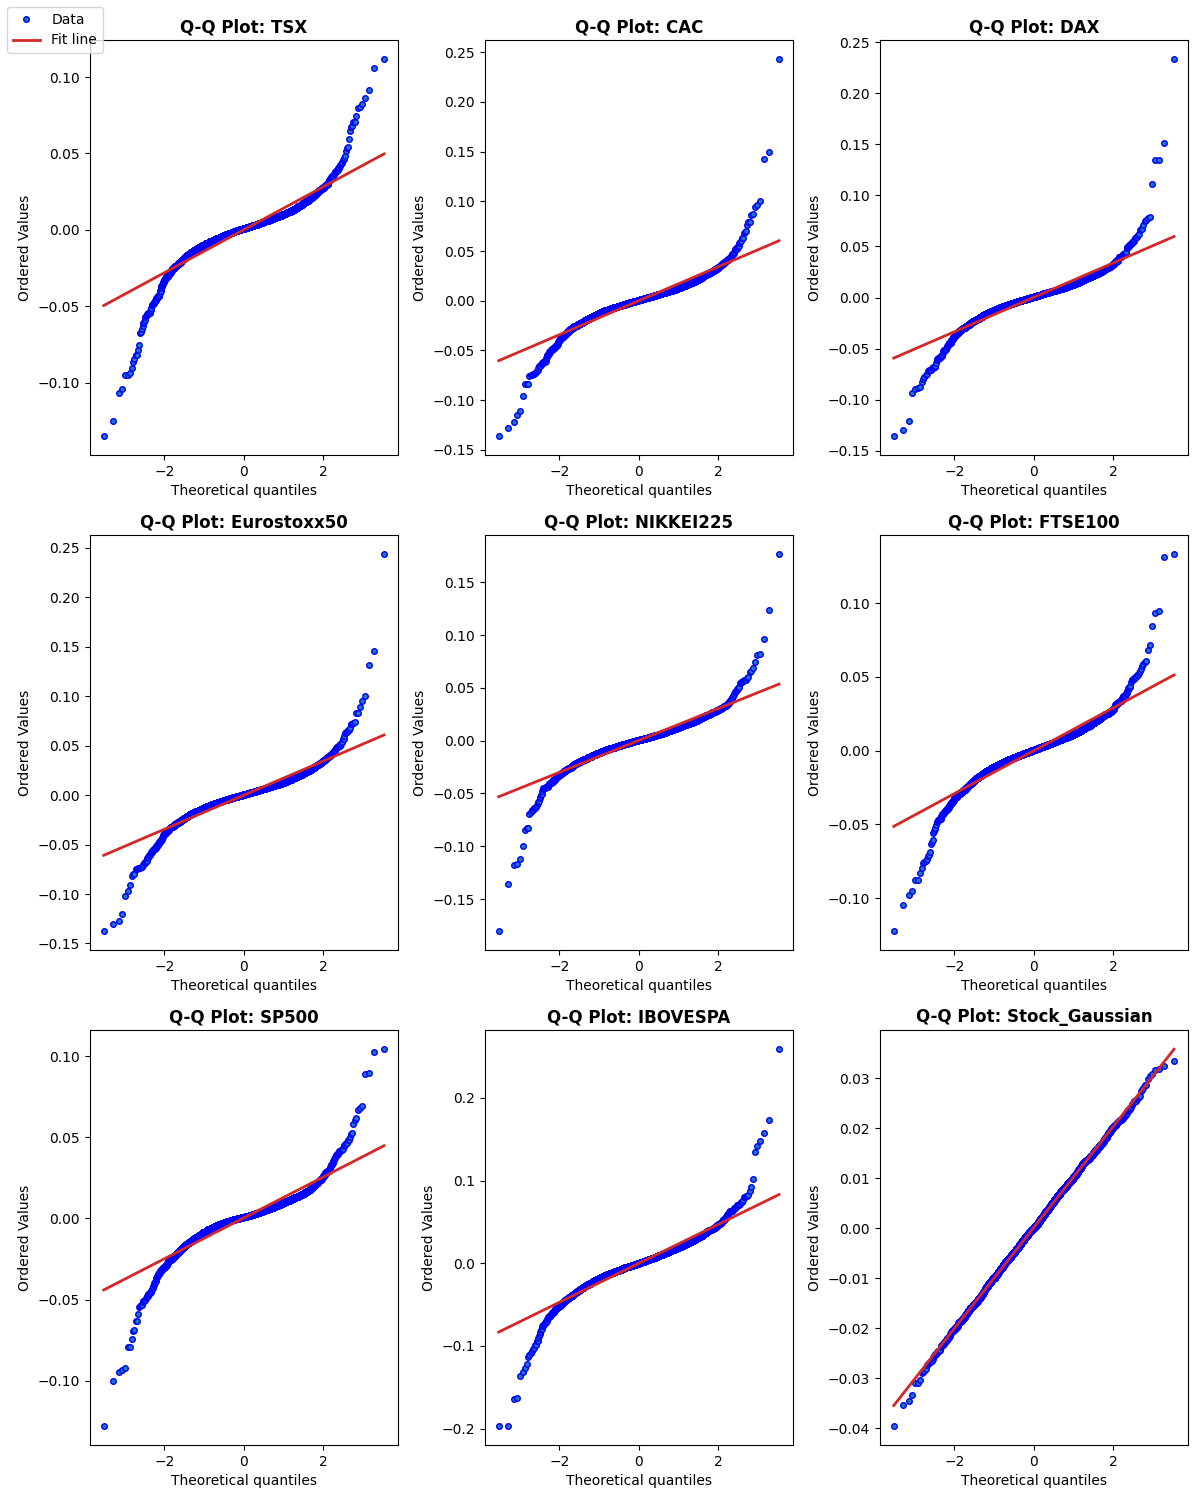

In [16]:
#| fig-cap: "Q-Q Plots of Daily Log Returns of Equity Indices in USD against Normal Distribution"
plot_qq_grid_norm_dist(df_returns_qq)

None of the stocks align with the reference (red) line, indicating that none of the return series follows a normal distribution. The observed S-shaped pattern reflects the presence of fat tails in the distributions, suggesting that a t-distribution may provide a more appropriate approximation.

## Question 2

Assuming 252 trading days per year.

### 2.1 Uncostrained Portfolio

In [17]:
mu = df_returns.mean() * 252
Sigma = df_returns.cov() * 252

n_assets = len(mu)

# Define the Quadprog Solver Function


def solve_qp_markowitz(Sigma, mu, target_return, non_negative_weights=False):
    """
    Solves for weights w to Min (1/2)w'Sigma w
    st: sum(w)=1, w'mu=target_return, w>=0
    """

    # 1. Quadratic term (G): The Covariance Matrix
    # quadprog requires a symmetric matrix. ensure it is perfectly symmetric.
    G = Sigma.values

    # 2. Linear term (a): Zeros (since we minimize Variance)
    a = np.zeros(n_assets)

    # 3. Constraints (C, b)
    # Equation: C.T * x >= b

    # Constraint 1: Sum of weights = 1 (Equality)
    # Vector of ones: [1, 1, ... 1]
    C1 = np.ones((n_assets, 1))
    b1 = np.array([1.0])

    # Constraint 2: Portfolio Return = Target Return (Equality)
    # Vector of means: [mu1, mu2, ... mun]
    C2 = mu.values.reshape(-1, 1)
    b2 = np.array([target_return])

    if non_negative_weights:
        # Constraint 3: Long Only (w >= 0) (Inequality)
        # Identity matrix: I * w >= 0
        C3 = np.eye(n_assets)
        b3 = np.zeros(n_assets)

    # Stack the constraint matrices
    # Note: quadprog expects C to be (n_vars x n_constraints)
    
    if non_negative_weights:
        C = np.hstack((C1, C2, C3))
        b = np.hstack((b1, b2, b3))
    else:
        C = np.hstack((C1, C2))
        b = np.hstack((b1, b2))
        
    # meq = 2 because the first two constraints 
    # (Sum=1, Return=Target) are equalities
    result = quadprog.solve_qp(G, a, C, b, meq=2)

    return result[0]  # This returns the optimal weights w

In [ ]:
# Define helper functions for efficient frontier computation

def solve_qp_gmv(Sigma, non_negative_weights=False):
    """
    Global Minimum Variance (GMV) portfolio:
    min (1/2) w' Sigma w
    s.t. sum(w) = 1
         w >= 0   (optional)
    """
    n_assets = Sigma.shape[0]

    G = Sigma.values
    a = np.zeros(n_assets)

    # Constraint 1: sum(w) = 1  -> in quadprog format C.T w >= b with meq=1
    C1 = np.ones((n_assets, 1))
    b1 = np.array([1.0])

    if non_negative_weights:
        # Constraint 2..: w >= 0
        C2 = np.eye(n_assets)
        b2 = np.zeros(n_assets)

        C = np.hstack((C1, C2))
        b = np.hstack((b1, b2))
    else:
        C = C1
        b = b1

    result = quadprog.solve_qp(G, a, C, b, meq=1)
    return result[0]

def find_mvp(mu, Sigma, non_negative_weights=False):
    """
    Find the Global Minimum Variance (GMV / MVP) portfolio.
    """
    mvp_weights = solve_qp_gmv(Sigma, non_negative_weights)

    mvp_return = float(np.dot(mvp_weights, mu))
    mvp_vol = float(np.sqrt(np.dot(mvp_weights.T, np.dot(Sigma, mvp_weights))))

    #return mvp_weights, mvp_return, mvp_vol

    
    try:
        low_return = mu.min() - 0.1
        mvp_weights = solve_qp_markowitz(Sigma, mu, low_return, 
                                         non_negative_weights)
        mvp_return = np.dot(mvp_weights, mu)
        mvp_vol = np.sqrt(np.dot(mvp_weights.T, np.dot(Sigma, mvp_weights)))
    except:
        try:
            mvp_weights = solve_qp_markowitz(Sigma, mu, mu.min(), 
                                             non_negative_weights)
            mvp_return = np.dot(mvp_weights, mu)
            mvp_vol = np.sqrt(np.dot(mvp_weights.T, 
                                     np.dot(Sigma, mvp_weights)))
        except:
            print("Could not find MVP")
    
    return mvp_weights, mvp_return, mvp_vol

# define the function that computes efficient frontier
def compute_frontier(mu, Sigma, mvp_return, non_negative_weights=False, 
                     n_points=50):

    if mvp_return is not None:
        target_returns = np.linspace(mvp_return, mu.max(), n_points)
    else:
        target_returns = np.linspace(mu.min(), mu.max(), n_points)
    
    frontier_volatility = []
    frontier_returns = []
    weights = []
    
    for r in target_returns:
        try:
            w = solve_qp_markowitz(Sigma, mu, r, non_negative_weights)
            port_return = float(np.dot(w, mu))
            port_vol = float(np.sqrt(np.dot(w.T, np.dot(Sigma, w))))

            weights.append(w)
            frontier_returns.append(port_return)
            frontier_volatility.append(port_vol)

        except Exception as e:
            # better: record/print occasionally instead of silently passing
            # print(f"Frontier failed at target return {r:.4f}: {e}")
            continue

    
    return frontier_volatility, frontier_returns, weights

def find_tangency_portfolio(frontier_returns, frontier_volatility, weights, 
                            rf=0.0253):

    excess_returns = np.array(frontier_returns) - rf
    sharpe_ratios = excess_returns / np.array(frontier_volatility)

    max_sharpe_idx = np.argmax(sharpe_ratios)
    
    tangency_vol = frontier_volatility[max_sharpe_idx]
    tangency_ret = frontier_returns[max_sharpe_idx]
    tangency_weights = weights[max_sharpe_idx]
    
    return (tangency_vol, tangency_ret, tangency_weights,
        sharpe_ratios, max_sharpe_idx)

# Compute unconstrained efficient frontier
mvp_weights, mvp_return, mvp_vol = find_mvp(mu, Sigma, 
                                            non_negative_weights=False)
frontier_volatility, frontier_returns, weights = compute_frontier(mu, Sigma, 
                                    mvp_return, non_negative_weights=False)

Here, the risk-free rate is assumed to be **2.53%**, corresponding to the yield on the 3-month U.S. Treasury bill (Bloomberg, 2026). The tangency portfolio constructed in the subsequent analysis is therefore based on this assumption.

In [19]:
# Find Tangency Portfolio (Max Sharpe)
rf = 0.0253  # 2.53% annual risk-free rate
tangency_vol, tangency_ret, tangency_weights, sharpe_ratios, max_sharpe_idx=(
    find_tangency_portfolio(frontier_returns, frontier_volatility, weights, 
                            rf))

In [20]:
# Define reporting function 
def print_portfolio_results(tangency_weights, tangency_ret, 
                            tangency_vol, sharpe_ratio,
                          mvp_weights, mvp_ret, mvp_vol, asset_names, 
                          long_only=False):
                          
    # Print portfolio allocation results.

    constraint_label = '(Long-Only, Max Sharpe Ratio)' \
    if long_only else '(Max Sharpe Ratio)'
    print(f'Tangency Portfolio Weights {constraint_label}:')
    for i, asset in enumerate(asset_names):
        print(f'{asset}: {tangency_weights[i]:.4f}')
    print(f'\nTangency Portfolio Return: {tangency_ret:.6f}')
    print(f'Tangency Portfolio Volatility: {tangency_vol:.6f}')
    print(f'Tangency Portfolio Sharpe Ratio: {sharpe_ratio:.6f}')
    
    if mvp_weights is not None:
        print(f'\nMinimum Variance Portfolio:')
        print(f'MVP Return: {mvp_ret:.6f}')
        print(f'MVP Volatility: {mvp_vol:.6f}')
        for i, asset in enumerate(asset_names):
            print(f'{asset}: {mvp_weights[i]:.4f}')

In [21]:
# Define plotting function
def plot_efficient_frontier(frontier_vol, frontier_ret, tangency_vol, 
                            tangency_ret, 
                          mvp_vol, mvp_ret, asset_vols, mu, asset_names, 
                          title, frontier_color='b-'):
                          
    plt.figure(figsize=(10, 6))
    
    # Plot Individual Assets
    plt.scatter(asset_vols, mu, color='red', label='Individual Assets', 
                zorder=5, s=100)
    for i, txt in enumerate(asset_names):
        plt.annotate(txt, (asset_vols[i], mu.iloc[i]), xytext=(5, 5),
             textcoords='offset points', fontsize=9)
    
    # Plot Efficient Frontier
    line_color = 'b-' if frontier_color == 'b-' else frontier_color
    plt.plot(frontier_vol, frontier_ret, line_color, linewidth=2.5, 
             label='Efficient Frontier')
    
    # Plot Tangency Portfolio
    marker_color = 'gold' if frontier_color == 'b-' else 'orange'
    plt.scatter(tangency_vol, tangency_ret, color=marker_color, marker='*', 
                s=400,
                edgecolors='black', linewidth=2, 
                label='Tangency Portfolio (Max Sharpe)', zorder=6)
    # Plot MVP if found
    if mvp_vol is not None:
        mvp_color = 'green' if frontier_color == 'b-' else 'blue'
        mvp_edge = 'darkgreen' if frontier_color == 'b-' else 'darkblue'
        plt.scatter(mvp_vol, mvp_ret, color=mvp_color, marker='o', s=150,
                    edgecolors=mvp_edge, linewidth=2, 
                    label='Minimum Variance Portfolio', zorder=6)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Annualized Volatility (Standard Deviation)', fontsize=11)
    plt.ylabel('Annualized Expected Return', fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
# Plot unconstrained frontier
order = np.argsort(frontier_volatility)
frontier_volatility = list(np.array(frontier_volatility)[order])
frontier_returns = list(np.array(frontier_returns)[order])
weights = list(np.array(weights, dtype=object)[order])
asset_vols = np.sqrt(np.diag(Sigma))

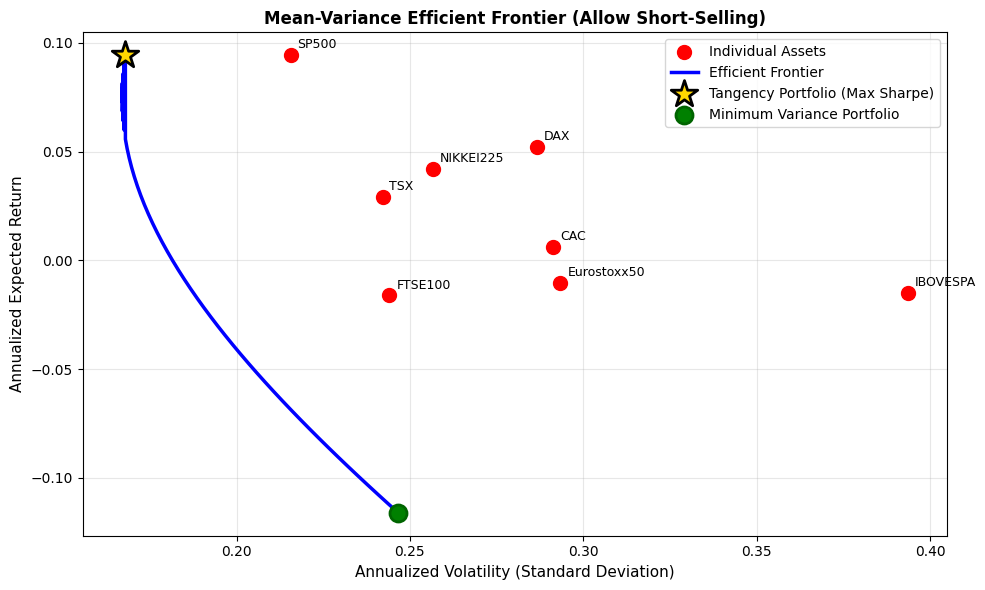

In [22]:
#| fig-cap: "Mean-Variance Efficient Frontier (Allow Short-Selling)"
plot_efficient_frontier(frontier_volatility, frontier_returns, 
                        tangency_vol, tangency_ret,
                       mvp_vol, mvp_return, asset_vols, mu, df_returns.columns,
                       'Mean-Variance Efficient Frontier (Allow Short-Selling)', 
                       'b-')

In [23]:
# Print unconstrained results
print_portfolio_results(tangency_weights, tangency_ret, tangency_vol, 
                        sharpe_ratios[max_sharpe_idx],
                       mvp_weights, mvp_return, mvp_vol, df_returns.columns, 
                       long_only=False)

Tangency Portfolio Weights (Max Sharpe Ratio):
TSX: 0.0533
CAC: 0.0240
DAX: 0.2496
Eurostoxx50: -0.3414
NIKKEI225: 0.3779
FTSE100: 0.1458
SP500: 0.6393
IBOVESPA: -0.1485

Tangency Portfolio Return: 0.094360
Tangency Portfolio Volatility: 0.167945
Tangency Portfolio Sharpe Ratio: 0.411205

Minimum Variance Portfolio:
MVP Return: -0.116154
MVP Volatility: 0.246654
TSX: 0.3426
CAC: -1.6290
DAX: -1.7865
Eurostoxx50: 3.0835
NIKKEI225: 0.3411
FTSE100: 0.6695
SP500: 0.0544
IBOVESPA: -0.0755


#### Portfolio Optimisation Results

The results of the mean–variance optimisation are summarised below for both the tangency (maximum Sharpe ratio) portfolio and the minimum variance portfolio.

#### Tangency Portfolio (Maximum Sharpe Ratio)

## NEED TO BE CHANGED WITH NEW RESULTS

When short-selling is permitted, the tangency portfolio assigns both positive and negative weights across assets. In particular, Eurostoxx50 (−0.3414) and IBOVESPA (−0.1485) are held as short positions, while the remaining indices are held long. The largest allocation is to the S&P 500 (63.93%), followed by the Nikkei 225 (37.79%) and the DAX (24.96%).

The tangency portfolio yields an expected annual return of 9.44% with a volatility of 16.79%, resulting in a Sharpe ratio of 0.3463. These results reflect the portfolio’s reliance on leverage and short positions in order to maximise risk-adjusted performance.

#### Minimum Variance Portfolio

The minimum variance portfolio also includes short positions, notably in the CAC (−0.1273), Eurostoxx50 (−0.0280), and IBOVESPA (−0.1418). The largest weights are allocated to the S&P 500 (58.58%) and the Nikkei 225 (37.46%), indicating their stabilising role in reducing overall portfolio volatility.

This portfolio achieves an expected return of 7.51% with a volatility of 16.69%, representing the lowest attainable risk among all feasible portfolios under the given assumptions.

### 2.2 Constraint Portfolio (Non-Negative Weights)

In [24]:
# Compute long-only efficient frontier
mvp_weights_lo, mvp_return_lo, mvp_vol_lo = find_mvp(
    mu, Sigma, non_negative_weights=True)

frontier_volatility_lo, frontier_returns_lo, weights_lo = compute_frontier(
    mu, Sigma, mvp_return_lo, non_negative_weights=True)

In [25]:
# Find Tangency Portfolio with Long-Only Constraint
tangency_vol_lo, tangency_ret_lo, tangency_weights_lo, sharpe_ratios_lo, \
max_sharpe_idx_lo = find_tangency_portfolio(
    frontier_returns_lo, frontier_volatility_lo, weights_lo, rf
)

In [26]:
# Plot long-only efficient frontier
order = np.argsort(frontier_volatility_lo)
frontier_volatility_lo_sorted = np.array(frontier_volatility_lo)[order]
frontier_returns_lo_sorted = np.array(frontier_returns_lo)[order]

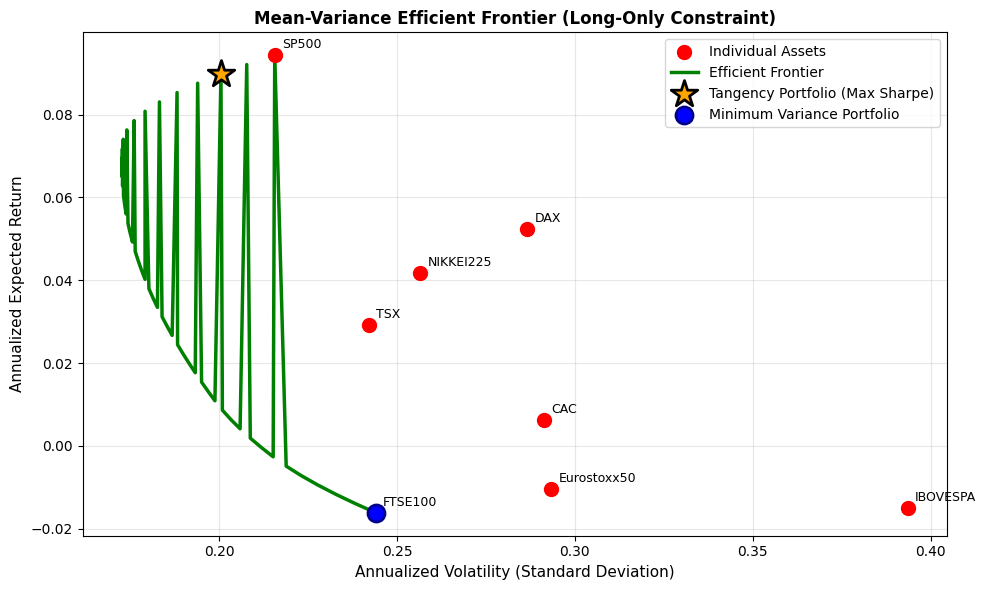

In [27]:
#| fig-cap: "Mean-Variance Efficient Frontier (Allow Short-Selling)"
plot_efficient_frontier(
    frontier_volatility_lo_sorted, frontier_returns_lo_sorted, 
    tangency_vol_lo, tangency_ret_lo,
    mvp_vol_lo, mvp_return_lo, asset_vols, mu, df_returns.columns,
    'Mean-Variance Efficient Frontier (Long-Only Constraint)', 'g-')

In [28]:
# Print long-only results
print_portfolio_results(tangency_weights_lo, tangency_ret_lo, tangency_vol_lo, 
                        sharpe_ratios_lo[max_sharpe_idx_lo],
                       mvp_weights_lo, mvp_return_lo, mvp_vol_lo, 
                       df_returns.columns, long_only=True)

Tangency Portfolio Weights (Long-Only, Max Sharpe Ratio):
TSX: 0.0000
CAC: -0.0000
DAX: -0.0000
Eurostoxx50: -0.0000
NIKKEI225: 0.0858
FTSE100: -0.0000
SP500: 0.9142
IBOVESPA: 0.0000

Tangency Portfolio Return: 0.089849
Tangency Portfolio Volatility: 0.200477
Tangency Portfolio Sharpe Ratio: 0.321978

Minimum Variance Portfolio:
MVP Return: -0.016154
MVP Volatility: 0.244067
TSX: -0.0000
CAC: 0.0000
DAX: 0.0000
Eurostoxx50: -0.0000
NIKKEI225: -0.0000
FTSE100: 1.0000
SP500: -0.0000
IBOVESPA: -0.0000


#### Analysis of Tangency and Minimum Variance Portfolios (Long-Only Constraint)

## NEED TO BE CHANGED WITH NEW RESULTS 

When a long-only constraint is imposed, prohibiting short-selling, the structure of the optimal portfolios changes substantially. In the case of the tangency portfolio, the optimisation allocates the entire portfolio weight to the S&P 500, with all other assets receiving zero weights. This outcome indicates that, among the available assets, the S&P 500 offers the highest risk-adjusted return when short-selling is not allowed.

Under this constraint, the tangency portfolio achieves an expected annual return of 9.44% with a volatility of 21.56%, resulting in a Sharpe ratio of 0.2698. Compared to the unconstrained case, the Sharpe ratio is notably lower, reflecting the loss of diversification benefits and the reduced efficiency of the portfolio when short positions cannot be used to enhance risk-adjusted performance.

For the minimum variance portfolio, the long-only restriction leads to a more diversified allocation relative to the tangency portfolio. Positive weights are assigned to the S&P 500 (55.46%), the Nikkei 225 (38.73%), and the FTSE 100 (5.81%), while all remaining assets receive zero weights. This allocation highlights the role of these indices in minimising portfolio volatility under non-negativity constraints.

The long-only minimum variance portfolio attains an expected return of 6.76% with a volatility of 17.26%, which represents the lowest achievable risk given the imposed constraints. Overall, the results illustrate that while long-only portfolios are more realistic from an implementation perspective, they generally lead to lower risk-adjusted performance compared to portfolios that allow short-selling and leverage.

#### Comparison of Constrained versus Unconstrained Optimisation

A comparison between constrained (long-only) and unconstrained (allowing short-selling) optimisation highlights the trade-off between theoretical efficiency and practical implementability. In the unconstrained framework, the optimisation exploits both long and short positions to improve diversification and enhance risk-adjusted returns. As a result, the tangency portfolio achieves a higher Sharpe ratio and lower volatility relative to its long-only counterpart, albeit at the cost of increased leverage and reliance on short positions.

By contrast, imposing non-negativity constraints on portfolio weights restricts the feasible investment set. This limitation leads to more concentrated portfolios, as observed in the long-only tangency portfolio, which allocates entirely to a single asset. Consequently, diversification benefits are reduced, and overall portfolio efficiency deteriorates, as reflected in the lower Sharpe ratio.

Nevertheless, constrained optimisation yields portfolios that are more realistic and easier to implement in practice, as they avoid short-selling and excessive leverage. The comparison therefore underscores a fundamental tension in portfolio construction: unconstrained optimisation offers superior theoretical performance, while constrained optimisation prioritises feasibility and robustness in real-world investment settings.

## Question 3

In [29]:
# Log Returns Calculation
log_returns = df_returns

In [30]:
# Rolling Window Setup
windows = []
for start_year in range(2010, 2018):  # 2010..2017 inclusive
    start = pd.Timestamp(f"{start_year}-01-01")
    end = pd.Timestamp(f"{start_year+4}-12-31")
    windows.append((start_year, start, end))

In [31]:
# Annualization Constants
TRADING_DAYS = 252

# Annualization Function
def annualize_mu_cov(daily_log_returns: pd.DataFrame):
    mu_d = daily_log_returns.mean().values  # daily mean vector
    cov_d = daily_log_returns.cov().values  # daily covariance matrix
    mu_a = mu_d * TRADING_DAYS
    cov_a = cov_d * TRADING_DAYS
    return mu_a, cov_a

def rolling_q2_weights(sample_returns: pd.DataFrame,
                       non_negative_weights: bool,
                       rf: float = rf, n_points: int = 50):
    mu = sample_returns.mean() * TRADING_DAYS
    Sigma = sample_returns.cov() * TRADING_DAYS

    mvp_weights, mvp_return, mvp_vol = find_mvp(mu, Sigma, 
                            non_negative_weights=non_negative_weights)
    frontier_vol, frontier_ret, weights = compute_frontier(
        mu, Sigma, mvp_return, non_negative_weights=non_negative_weights,
        n_points=n_points)

    if len(frontier_ret) == 0:
        raise ValueError("Frontier empty (all QP solves failed).")

    tvol, tret, tw, sharpe_ratios, max_idx = find_tangency_portfolio(
        frontier_ret, frontier_vol, weights, rf=rf)

    return tw, tret, tvol, mvp_weights, mvp_return, mvp_vol

In [32]:
# Rolling Window Portfolio Optimization

assets = log_returns.columns.tolist()

rows = []
w_uncon_list = []
w_noshort_list = []

rf = 0.0253 # Annual risk-free rate

for start_year, start, end in windows:
    sample = log_returns.loc[start:end].dropna(how="any")

    # Skip if insufficient data
    if len(sample) < 200:
        continue

    # Annualize
    mu_a, cov_a = annualize_mu_cov(sample)

    mu_s = pd.Series(mu_a, index=assets)
    Sigma_df = pd.DataFrame(cov_a, index=assets, columns=assets)

    # Unconstrained (short-selling allowed)
    mvp_weights, mvp_return, mvp_vol = find_mvp(
        mu_s, Sigma_df, non_negative_weights=False
    )

    frontier_volatility, frontier_returns, weights = compute_frontier(
        mu_s, Sigma_df, mvp_return, non_negative_weights=False
    )

    if len(frontier_returns) == 0:
        w_uncon = np.full(len(assets), np.nan)
    else:
        tangency_vol, tangency_ret, w_uncon, sharpe_ratios, max_sharpe_idx = (
            find_tangency_portfolio(
                frontier_returns, frontier_volatility, weights, rf=rf
            )
        )

    # No-short (long-only)
    mvp_weights_lo, mvp_return_lo, mvp_vol_lo = find_mvp(
        mu_s, Sigma_df, non_negative_weights=True
    )

    frontier_volatility_lo, frontier_returns_lo, weights_lo = compute_frontier(
        mu_s, Sigma_df, mvp_return_lo, non_negative_weights=True
    )

    if len(frontier_returns_lo) == 0:
        w_ns = np.full(len(assets), np.nan)
    else:
        tangency_vol_lo, tangency_ret_lo, w_ns, sharpe_ratios_lo, max_sharpe_idx_lo = (
            find_tangency_portfolio(
                frontier_returns_lo, frontier_volatility_lo, weights_lo, rf=rf
            )
        )

    rows.append(f"{start_year}-{start_year+4}")
    w_uncon_list.append(w_uncon)
    w_noshort_list.append(w_ns)

w_uncon_df = pd.DataFrame(w_uncon_list, index=rows, columns=assets)
w_noshort_df = pd.DataFrame(w_noshort_list, index=rows, columns=assets)

In [34]:
#| tbl-cap: "Rolling Window Tangency Portfolio Weights (Allow Short-Selling)"
w_uncon_df

,TSX,CAC,DAX,Eurostoxx50,NIKKEI225,FTSE100,SP500,IBOVESPA
2010-2014,0.183669,-0.413859,0.067679,0.013116,0.299516,0.356260,0.568595,-0.074977
2011-2015,0.159923,-0.254812,0.055767,-0.034924,0.288621,0.278661,0.627631,-0.120868
2012-2016,0.203651,0.186642,0.277436,-0.553972,0.193435,0.081375,0.662088,-0.050655
2013-2017,0.199489,0.356855,0.390305,-0.779372,0.166709,0.048398,0.645515,-0.027900
2014-2018,0.146801,0.553894,0.394946,-0.998019,0.239035,0.087147,0.587357,-0.011161
2015-2019,0.217873,0.471513,0.336279,-0.867143,0.258437,0.086828,0.514238,-0.018025
2016-2020,0.054533,0.818490,0.617963,-1.456461,0.480770,0.025790,0.499369,-0.040454
2017-2021,0.008711,0.847952,0.260908,-1.076582,0.502753,0.043642,0.533047,-0.120431


In [35]:
#| tbl-cap: "Rolling Window Tangency Portfolio Weights (Long-Only Constraint)"
w_noshort_df.round(4)

,TSX,CAC,DAX,Eurostoxx50,NIKKEI225,FTSE100,SP500,IBOVESPA
2010-2014,0.0000,0.0,-0.0,0.0,-0.0000,-0.0,1.0000,-0.0000
2011-2015,-0.0000,-0.0,-0.0,0.0,-0.0000,-0.0,1.0000,-0.0000
2012-2016,0.0000,0.0,-0.0,0.0,0.1371,0.0,0.8629,-0.0000
2013-2017,-0.0000,0.0,0.0,0.0,0.1453,-0.0,0.8547,-0.0000
2014-2018,0.0000,-0.0,-0.0,-0.0,0.0000,0.0,1.0000,-0.0000
2015-2019,0.0107,-0.0,-0.0,-0.0,0.3018,0.0,0.6848,0.0026
2016-2020,-0.0000,0.0,-0.0,-0.0,0.3849,0.0,0.5422,0.0728
2017-2021,0.0000,0.0,0.0,-0.0,0.2361,0.0,0.7639,0.0000


In [36]:
# Market Capitalization Weights Loading
asset_names = w_noshort_df.columns.to_list()
mc_raw = df_currencies = pd.read_excel('PS1_data.xlsx', 
                    sheet_name = 'market_cap', header=None)                             
# Extract Tickers and Weights
mc_tickers = mc_raw.iloc[1, 1:].tolist()
mc_weights = pd.to_numeric(mc_raw.iloc[2, 1:], errors="coerce").values
# Create Market Cap Weights Series
mc_series = pd.Series(mc_weights, index=asset_names, name="mkt_cap_weight")
# Reindex to match assets order
mc_series = mc_series.reindex(assets)

In [37]:
#| tbl-cap: "Market Capitalization Weights of Equity Indices"
mc_series

TSX            0.041834
CAC            0.043180
DAX            0.036197
Eurostoxx50    0.090955
NIKKEI225      0.092523
FTSE100        0.081589
SP500          0.602344
IBOVESPA       0.011378
Name: mkt_cap_weight, dtype: float64

In [38]:
# Distance Calculation Function
def weight_distances(w_df: pd.DataFrame, w_ref: pd.Series):
    aligned_ref = w_ref.reindex(w_df.columns).values
    W = w_df.values
    l1 = np.nansum(np.abs(W - aligned_ref), axis=1)
    l2 = np.sqrt(np.nansum((W - aligned_ref) ** 2, axis=1))
    out = pd.DataFrame({"L1_distance": l1, "L2_distance": l2}, index=w_df.index)
    return out

# Compute Distances to Market Cap Weights
dist_uncon = weight_distances(w_uncon_df, mc_series)
dist_noshort = weight_distances(w_noshort_df, mc_series)

In [39]:
#| tbl-cap: "Distance between Tangency Portfolio Weights and Market Capitalization Weights (Allow Short-Selling)"
dist_uncon

,L1_distance,L2_distance
2010-2014,1.309964,0.602443
2011-2015,1.112233,0.463026
2012-2016,1.414348,0.733821
2013-2017,1.885592,1.008028
2014-2018,2.253000,1.268323
2015-2019,2.151215,1.121892
2016-2020,3.516045,1.871191
2017-2021,2.879427,1.501432


In [40]:
#| tbl-cap: "Distance between Tangency Portfolio Weights and Market Capitalization Weights (Long-Only Constraint)"
dist_noshort

,L1_distance,L2_distance
2010-2014,0.795312,0.432059
2011-2015,0.795312,0.432059
2012-2016,0.610266,0.299764
2013-2017,0.610266,0.294006
2014-2018,0.795312,0.432059
2015-2019,0.583487,0.264085
2016-2020,0.707750,0.335781
2017-2021,0.610266,0.258259


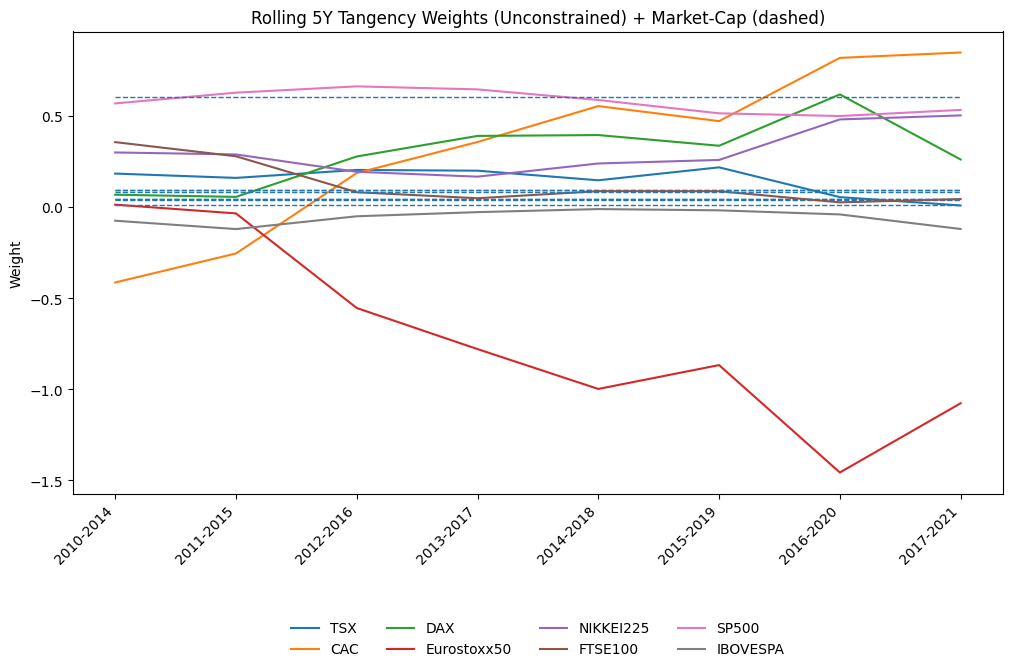

In [41]:
#| fig-cap: "Rolling 5-Year Tangency Portfolio Weights (Allow Short-Selling) with Market-Capitalization Weights"
# Plotting Rolling Weights with Market-Cap Weights 
x = np.arange(len(w_uncon_df.index))
labels = w_uncon_df.index.tolist()

# Plot 1: Unconstrained
plt.figure(figsize=(12, 6))
for a in assets:
    plt.plot(x, w_uncon_df[a].values, label=a)
    plt.hlines(mc_series[a], x.min(), x.max(), linestyles="dashed", 
               linewidth=1)

plt.xticks(x, labels, rotation=45, ha="right")
plt.title("Rolling 5Y Tangency Weights (Unconstrained) + Market-Cap (dashed)")
plt.ylabel("Weight")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=4,
    frameon=False
)
plt.show()

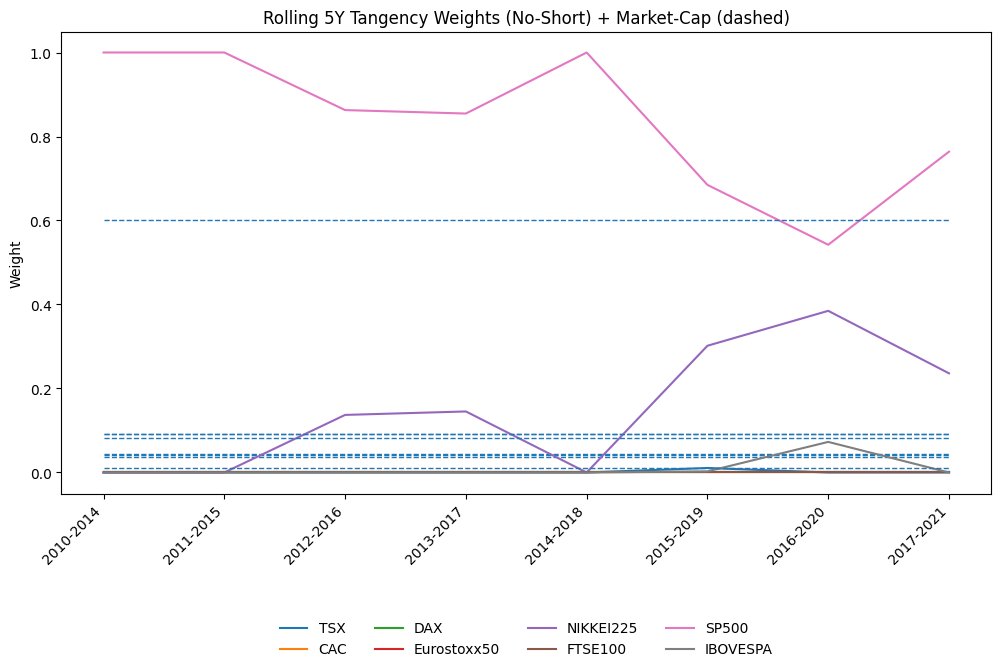

In [42]:
#| fig-cap: "Rolling 5-Year Tangency Portfolio Weights (Long-Only Constraint) with Market-Capitalization Weights"
# Plot 2: No-short
plt.figure(figsize=(12, 6))
for a in assets:
    plt.plot(x, w_noshort_df[a].values, label=a)
    plt.hlines(mc_series[a], x.min(), x.max(), linestyles="dashed", 
               linewidth=1)

plt.xticks(x, labels, rotation=45, ha="right")
plt.title("Rolling 5Y Tangency Weights (No-Short) + Market-Cap (dashed)")
plt.ylabel("Weight")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=4,
    frameon=False
)
plt.show()

### Rolling Mean–Variance Optimisation: Stability and Comparison with Market-Capitalization Weights

The rolling five-year mean–variance analysis reveals pronounced instability in optimal portfolio weights over time. In the unconstrained setting, the tangency portfolio is characterised by extremely large positive and negative allocations, reflecting the well-documented sensitivity of mean–variance optimisation to estimation error in expected returns and covariance matrices. These extreme positions fluctuate considerably across rolling windows, indicating low temporal stability and limited practical feasibility.

Introducing a no short-selling constraint (weights ≥ 0) results in substantially more stable and interpretable portfolio compositions. Under this restriction, the tangency portfolios tend to be concentrated in a limited subset of assets, with portfolio weights evolving more smoothly over time rather than exhibiting abrupt sign reversals. This behaviour highlights the binding role of the non-negativity constraint, which alleviates the impact of estimation error, albeit at the expense of reduced diversification.

A comparison between mean–variance optimised portfolios and market-capitalisation-weighted portfolios further underscores these differences. While market-cap weights remain constant through time, mean–variance portfolios—particularly in the unconstrained case—exhibit significant deviations. Even when short-selling is prohibited, the optimised portfolios frequently overweight assets with strong recent performance relative to their market capitalisation, emphasising the contrast between return-driven optimisation and capitalisation-based allocation strategies.

## References

1. Bloomberg (2026) *U.S. Government Bonds – Treasury Yields*. Available at: https://www.bloomberg.com/markets/rates-bonds/government-bonds/us (Accessed: 20 January 2026).